Group: 

        Ait El Menceur Ilyès


# Portfolio strategies

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os

## Data preparation

### Data Loading

In [55]:
file_name = "./sbf120_as_of_end_2018.xlsx"

data = pd.DataFrame()
try:
    if os.path.isfile(file_name):  # check if data is locally present, or download the xlsx file
        print('Loading Data localy')
        data = pd.read_excel(file_name, sheet_name = 'Data') 
        label = pd.read_excel(file_name, sheet_name = 'Compo 31122018') 
    else: # Dataset Not Found
        raise FileNotFoundError
except Exception as e:
    # Download the Dataset
    print('Downloading the Dataset')
    label = pd.read_excel('https://www.oliviergueant.com/uploads/4/3/0/9/4309511/sbf120_as_of_end_2018.xlsx', sheet_name = 'Compo 31122018') 
    data = pd.read_excel('https://www.oliviergueant.com/uploads/4/3/0/9/4309511/sbf120_as_of_end_2018.xlsx', sheet_name = 'Data')
print('Data loaded')


loading Data localy
Data loaded


### Marketcap

In [40]:
agg_mkt_cap_data = data.filter(regex='MARKETCAP').copy()
agg_mkt_cap_data.columns = label['Ticker']
agg_mkt_cap_data['Date'] = pd.to_datetime(data.loc[:, 'QDT FP Equity'], unit= 'D', origin= '1899-12-30')
agg_mkt_cap_data.set_index('Date',inplace=True)
agg_mkt_cap_data.fillna(value = 0.0, inplace = True) # fill empty value with 0 
print(agg_mkt_cap_data.head())

Ticker      QDT FP Equity  DIM FP Equity  RUI FP Equity  OR FP Equity  \
Date                                                                    
2010-12-31      2074.1424       640.6889      1224.8148    49784.4831   
2011-01-03      2080.8229       641.5386      1236.6203    51234.6330   
2011-01-04      2116.7705       640.6889      1239.5716    50958.9847   
2011-01-05      2115.8161       641.3687      1257.7014    50731.2752   
2011-01-06      2149.2187       642.3883      1257.8420    50677.3440   

Ticker      DG FP Equity  ALD FP Equity  URW NA Equity  KORI FP Equity  \
Date                                                                     
2010-12-31    22463.6902         0.0000     13574.0125        528.1141   
2011-01-03    23037.9831      5778.6820     13794.1317        538.7085   
2011-01-04    22875.0827      5782.7231     13688.6579        540.9557   
2011-01-05    22571.3701      5697.8613     13523.5686        544.4872   
2011-01-06    22317.5758      5536.2198     

### Price

In [41]:
agg_price_data = data.filter(regex='PX_LAST').copy()
agg_price_data.columns = label['Ticker']
agg_price_data['Date'] = pd.to_datetime(data.loc[:,'QDT FP Equity'], unit='D', origin='1899-12-30').copy()
agg_price_data.set_index('Date', inplace=True)
agg_price_data.fillna(method='backfill', inplace=True) # replace Na values by previous values
print(agg_price_data.head())


Ticker      QDT FP Equity  DIM FP Equity  RUI FP Equity  OR FP Equity  \
Date                                                                    
2010-12-31          65.20           6.28        21.1225         83.08   
2011-01-03          65.41           6.29        21.3261         85.50   
2011-01-04          66.54           6.28        21.3770         85.04   
2011-01-05          66.51           6.29        21.6896         84.66   
2011-01-06          67.56           6.30        21.6920         84.57   

Ticker      DG FP Equity  ALD FP Equity  URW NA Equity  KORI FP Equity  \
Date                                                                     
2010-12-31       40.2799          14.30        145.441         15.1940   
2011-01-03       41.3097          14.30        147.799         15.4988   
2011-01-04       41.0176          14.31        146.669         15.5635   
2011-01-05       40.4730          14.10        144.900         15.6651   
2011-01-06       39.9878          13.70     

### Data Selection

We consider an investment universe of 10 stocks corresponding to those having the highest market capitalization as
of end 2018.

In [42]:
best_10_index_marketcap = agg_mkt_cap_data.loc['2018-12-31'].nlargest(n=10).index
print(best_10_index_marketcap)
agg_market_cap_10_first = agg_mkt_cap_data[best_10_index_marketcap]['2019-01-01':'2020-01-01']
agg_price_10_first = agg_price_data[best_10_index_marketcap]['2019-01-01':'2020-01-01']
print(agg_price_10_first)

Index(['MC FP Equity', 'TTE FP Equity', 'OR FP Equity', 'SAN FP Equity',
       'AIR FP Equity', 'KER FP Equity', 'RMS FP Equity', 'BNP FP Equity',
       'EL FP Equity', 'AI FP Equity'],
      dtype='object', name='Ticker')
Ticker      MC FP Equity  TTE FP Equity  OR FP Equity  SAN FP Equity  \
Date                                                                   
2019-01-02        253.30         46.655        199.60          75.40   
2019-01-03        243.65         46.255        197.20          74.66   
2019-01-04        251.15         47.410        200.00          75.34   
2019-01-07        250.70         47.300        197.45          73.84   
2019-01-08        258.55         47.200        198.65          74.42   
...                  ...            ...           ...            ...   
2019-12-23        413.80         49.355        265.30          90.71   
2019-12-24        414.10         49.475        264.50          90.63   
2019-12-27        417.60         49.290        266.10  

## Portfolio Construction

### Strategy Class

In [43]:
class Strategy:

    def __init__(self, name, returns,initial_capital= 1000.):
        self.name = name
        self.returns = returns
        self.initial_capital = initial_capital
        self.pnl = np.c_[np.array([self.initial_capital]), self.initial_capital * np.cumprod(1. + returns.to_numpy()).reshape(1, -1)].flatten()

    def volatility(self):
        return np.std(self.returns)*np.sqrt(252)

    def sharpe_ratio(self):
        return np.mean(self.returns)*np.sqrt(252)/np.std(self.returns)

    def max_dd(self):
        return 1. - np.min(np.flip(np.minimum.accumulate(np.flip(self.pnl)))/self.pnl)

    def max_dd_2(self):
        return np.max(1. - self.pnl/np.maximum.accumulate(self.pnl))
    def generate_pnl_graph(self,axes,color ='b'):
        axes.plot(self.returns.index, self.pnl[1:],color=color, label=self.name + ' (vol: %.2f, Sharpe: %.2f, MDD: %.2f)'%
                                                          (self.volatility(), self.sharpe_ratio(), self.max_dd_2()))
        axes.set_xlabel('Time')
        axes.set_ylabel('PnL')
        axes.legend()
        axes.tick_params(axis='x', rotation=45)
        axes.set_title(f'PnL of the strategy {self.name}')
        axes.grid(axis='x', linestyle='--')
        
    def generate_weights_distribution(self,data,axes,labels):
        axes.pie(data,labels=labels, autopct='%1.1f%%', startangle=140)
        axes.set_title(f'Weights Distribution of the strategy {self.name}')

### Equally weighted portfolio

In [44]:
class EquallyWeighted(Strategy):
    """
    EquallyWeighted Portfolio that distribute equally the weight of each portfolio
    """
    def __init__(self, name, returns,initial_capital= 1000.):
        """
        Parameters
        ----------
        name : str
        returns : pd.DataFrame
            Dataframe containing each assets return
        """
        self.weights = np.ones(returns.shape[1])*(1/returns.shape[1])
        returns_CW = (returns * self.weights).sum(axis=1)
        super().__init__(name, returns_CW,initial_capital)

In [45]:
equally_weighted = EquallyWeighted('Equally weighted', agg_price_10_first.pct_change().dropna())

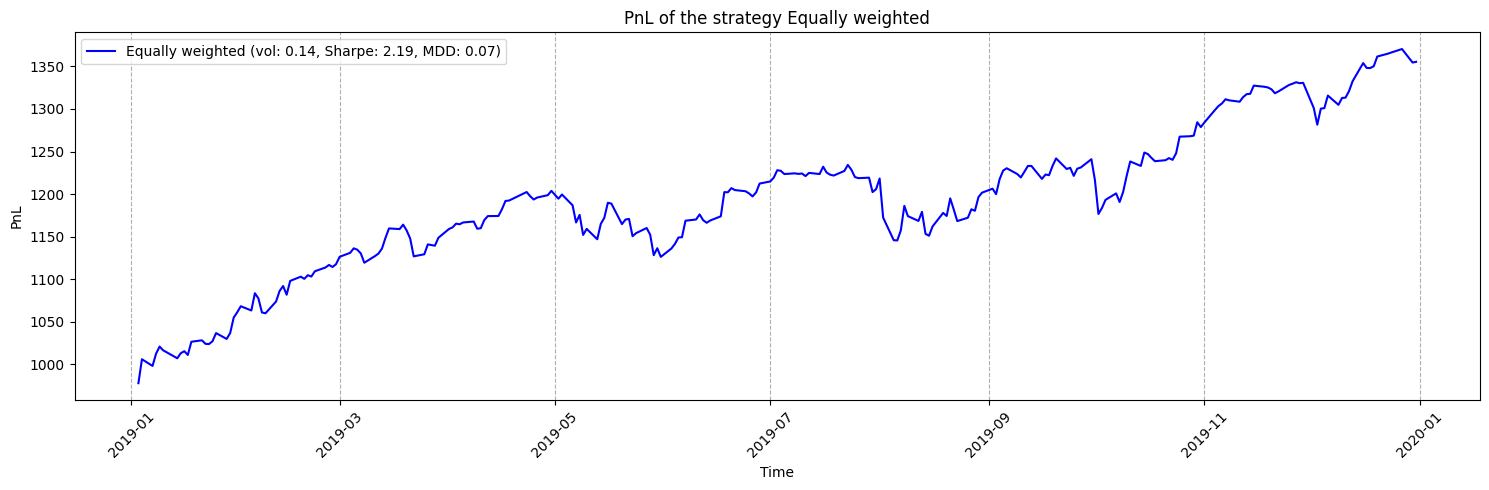

In [46]:
fig, axes = plt.subplots(1,1,figsize=(15, 5))
equally_weighted.generate_pnl_graph(axes = axes)
fig.tight_layout()
# fig.savefig(f'{equally_weighted.name}.pdf')
plt.show()

### Markowitz minimum-variance portfolio 

The primary objective of constructing a Minimum Variance Portfolio is to find an allocation of assets that provides the lowest possible level of risk for a given set of assets.

In order to build such a portfolio, we want to solve the following minimization problem : 

<center>

$ \min $ w' $ \sum _ {i=1}^ {n} $ w, with  $ \sum _ {i}^ {i} $ $ w_ {i} $ =1.

</center>

As we want to construct our portfolio based on data starting from 2017 to 2018, we will use a dataset as a training set and visualize performances over 2019

In [47]:
agg_price_10_first.pct_change().cov().dropna().head()


Ticker         MC FP Equity  TTE FP Equity  OR FP Equity  SAN FP Equity  \
Ticker                                                                    
MC FP Equity       0.000224       0.000068      0.000087       0.000060   
TTE FP Equity      0.000068       0.000121      0.000039       0.000036   
OR FP Equity       0.000087       0.000039      0.000135       0.000067   
SAN FP Equity      0.000060       0.000036      0.000067       0.000150   
AIR FP Equity      0.000124       0.000061      0.000066       0.000055   

Ticker         AIR FP Equity  KER FP Equity  RMS FP Equity  BNP FP Equity  \
Ticker                                                                      
MC FP Equity        0.000124       0.000169       0.000123       0.000099   
TTE FP Equity       0.000061       0.000083       0.000042       0.000088   
OR FP Equity        0.000066       0.000072       0.000069       0.000023   
SAN FP Equity       0.000055       0.000056       0.000049       0.000034   
AIR FP Equity       0.000216       0.000118       0.000089       0.000086   

Ticker         EL FP Equity  AI FP Equity  
Ticker                                     
MC FP Equity       0.000080      0.000083  
TTE FP Equity      0.000037      0.000050  
OR FP Equity       0.000052      0.000061  
SAN FP Equity      0.000035      0.000049  
AIR FP Equity      0.000057      0.000066

We can see that some covariance values tend to be small, this might be an issue for our minimization problem.
We will therefore apply a factor of 1000 to our covariance matrix 

In [48]:
class MMVWeighted(Strategy):
    """
    MMVWeighted Min Variance Portfolio
    """
    def __init__(self, name, returns,training_set,initial_capital= 1000.):
        """
        name : str
        returns : pd.DataFrame
            Dataframe containing each assets return, 
        training_set : pd.DataFrame
            Dataframe containing each assets return, this dataset is used to compute assets weights.
        """
        self.training_cov = training_set.cov()*1000
        self.weights = np.ones(returns.shape[1])*(1/returns.shape[1])
        self.weights = self.find_weights(weights=self.weights)
        self.returns = (returns * self.weights).sum(axis=1)
        super().__init__(name, self.returns,initial_capital)
        
    def portfolio_variance(self,weights):
        """
        portfolio_variance Compute the variance of the portfolio

        Parameters
        ----------
        weights : pd.DataFrame
            weight of each assets

        Returns
        -------
        float
            Variance
        """
        return np.dot(weights.T, np.dot(self.training_cov,weights))
    
    def find_weights(self,weights):
        """
        find_weights Compute each assets weights 

        Parameters
        ----------
        weights : pd.DataFrame
            Initial assets weights

        Returns
        -------
        pd.DataFrame
            optimal portfolio weights
        """
        constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}),
        result = minimize(self.portfolio_variance, weights, constraints=constraints)
        
        x = result.x
        return x

In [49]:
training_set = agg_price_data[best_10_index_marketcap]['2017-01-01':'2018-12-31'].pct_change().dropna()

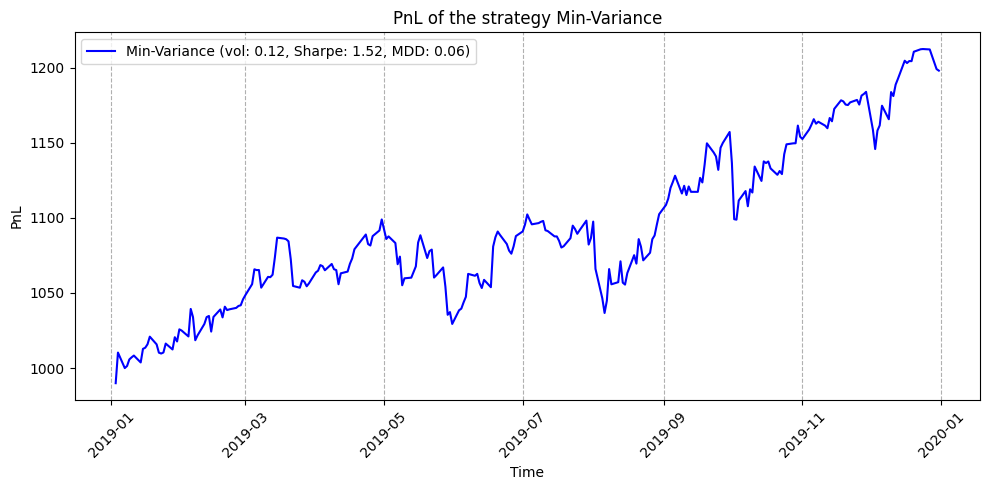

In [50]:
min_variance_portfolio = MMVWeighted('Min-Variance',agg_price_10_first.pct_change().dropna(), training_set)

fig, axes = plt.subplots(1,1,figsize=(10,5))
min_variance_portfolio.generate_pnl_graph(axes = axes)
fig.tight_layout()

# fig.savefig(f'{min_variance_portfolio.name}.pdf')
plt.show()


### ERC portfolio

In an ERC portfolio, the goal is to achieve risk parity, where each asset contributes equally to the total portfolio risk


* The covariance matrix is computed over 2017-2018 and not updated

* Equally weighted portfolios can serve as benchmarks for comparing the performance of more sophisticated portfolio ERC. We can assess whether the added complexity and customization of the ERC approach result in superior risk-adjusted returns.

We define $ \sigma $ (w) the portfolio risk : 
<center>

$ \sigma $ (w)= $ \sqrt {w^ {T}\sum _ {i}w} $ 

</center>

The risk contribution is a measure of how much that asset contributes to the overall risk of the portfolio : 
<center>

$ RC_{i} $ (w)= $  \sum _ {i}^{} w_{i} \frac{\partial \sigma(w)}{\partial w_{i}} /dt$ 

</center>

The goal is to minimize the following equation : 
<center>

 $ \min $ $ \sum _ {i}^{j} $ [ $ w_ {i} $ $ (\sum _ {i=1}^ {n}w)_ {i} $ - $ w_ {j} $ ( $ \sum _ {w)j} $ j] $ ^ {2} $ 
</center>

Which can be simplified in our case by the following: 

<center>

  $ \min $ $ \sum _ {i}^{j} $ [$RC_{i}(w)$ - $ \frac{1}{n}$ ]$^{2} $ 
</center>

In [51]:
class ECR_Weighted(Strategy):
    """
    ECR_Weighted Equal Risk Contribution (ERC) portfolio
    """
    def __init__(self, name, returns,training_set,initial_capital= 1000.):
        self.nb_assets = returns.shape[1]
        self.training_cov = training_set.cov()*1000
        self.weights = np.ones(self.nb_assets)*(1/self.nb_assets) # initial weights
        self.weights = self.find_weights(initial_weights=self.weights)
        self.returns = (returns * self.weights).sum(axis=1)
        super().__init__(name, self.returns,initial_capital)
        
    def portfolio_risk(self,weights):
        """
        portfolio_risk compute portfolio risk

        Compute the portfolio risk

        Parameters
        ----------
        weights : pd.DataFrame

        Returns
        -------
        float
            Portfolio risk
        """
        return np.sqrt(np.dot(weights.T, np.dot(self.training_cov,weights)))
    
    def risk_contribution(self,weights):
        """
        risk_contribution risk contribution

        Compute the risk contribution of all assests given it weights

        Parameters
        ----------
        weights : pd.DataFrame
        
        Returns
        -------
        pd.DataFrame
            Risk contribution
        """
        portfolio_risk = self.portfolio_risk(weights=weights)
        asset_contributions =  np.dot(self.training_cov, weights) *weights / portfolio_risk
        return asset_contributions
    
    def minimization_prbl(self,weights):
        """
        minimization_prbl 

        Represent the equation to be minimize in order to find the optimal weight

        Parameters
        ----------
        weights : pd.DataFrame

        Returns
        -------
        pd.DataFrame
            Optimal weights
        """
        target_risk_contrib = 1 / self.nb_assets 
        return np.sum((self.risk_contribution(weights) - target_risk_contrib) ** 2)
    
    def find_weights(self,initial_weights):
        """
        find_weights 

        Method to find optimal weights

        Parameters
        ----------
        initial_weights : 

        Returns
        -------
        pd.DataFrame
            Optimal weights
        """
        constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
        result = minimize(self.minimization_prbl, initial_weights,method='SLSQP', constraints=constraints,bounds=[(0, 1) for _ in range(self.nb_assets)])
        return result.x

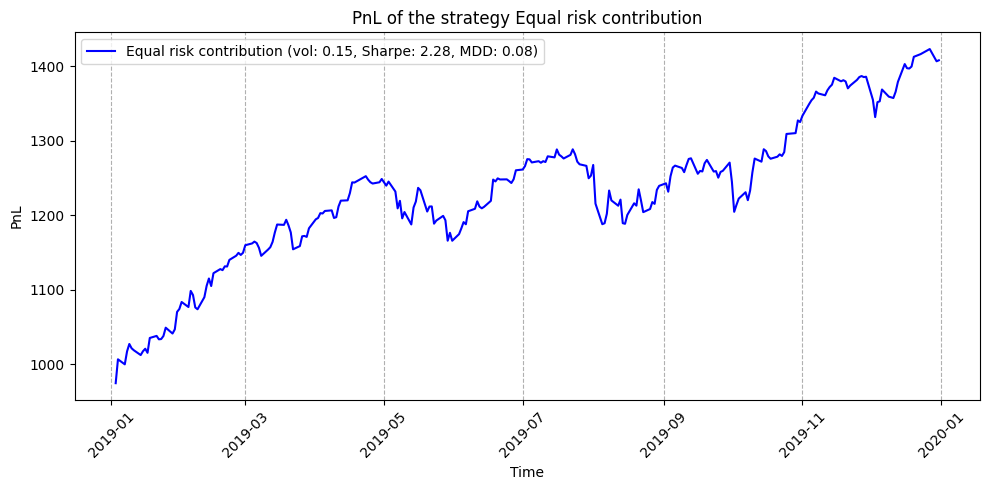

In [52]:
erc_portfolio = ECR_Weighted('Equal risk contribution',agg_price_10_first.pct_change().dropna(), training_set)

fig, axes = plt.subplots(1,1,figsize=(10,5))
erc_portfolio.generate_pnl_graph(axes = axes)
fig.tight_layout()

# fig.savefig(f'{erc_portfolio.name}.pdf')
plt.show()

## Performance analysis

### PnL

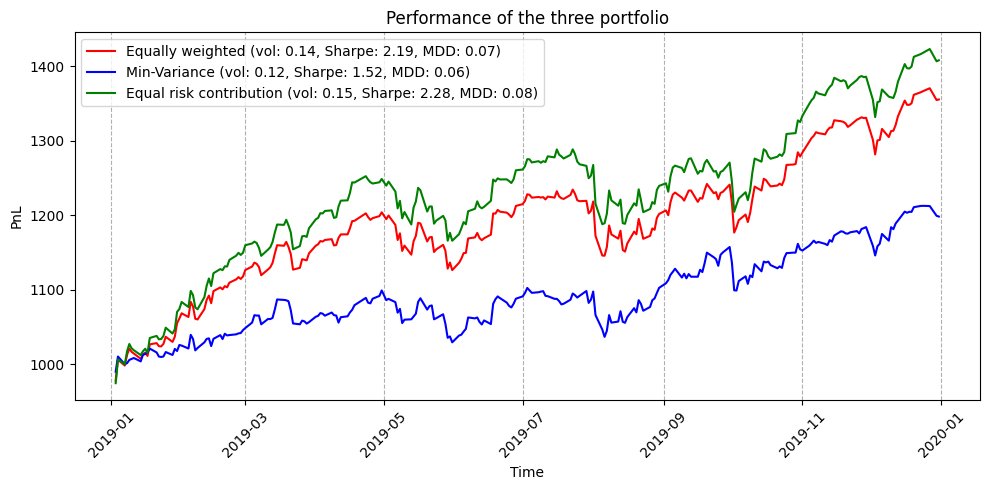

In [53]:
fig, axes = plt.subplots(1,1,figsize=(10, 5))
equally_weighted.generate_pnl_graph(axes = axes,color="r")
min_variance_portfolio.generate_pnl_graph(axes = axes,color="b")
erc_portfolio.generate_pnl_graph(axes = axes,color="g")

fig.tight_layout()
plt.title("Performance of the three portfolio")
# fig.savefig(f'Performance of the three portfolio.pdf')

plt.show()


Regarding the portfolio distribution, we can infere the following statements
* Min-Variance strategy gives us the lowest global risk; this is a risk advert approach
* Min-Variance strategy has the lowest maximum drawdown; this portfolio favors capital preservation
* Min-Variance strategy displays the lowest Sharpe ratio and the lowest Pnl, which shows that a risk-averse approach doesn't maximize profit 
* The equally risk contribution portfolio gives us better Pnl, this portfolio optimizes the risk-adjusted return
* The equal risk portfolio looks similar to the equally weighted portfolio, it is used as a model to optimize the distribution based on risk contribution

also, for the Min-Variance strategy, long position has been taken.

### Portfolio distribution

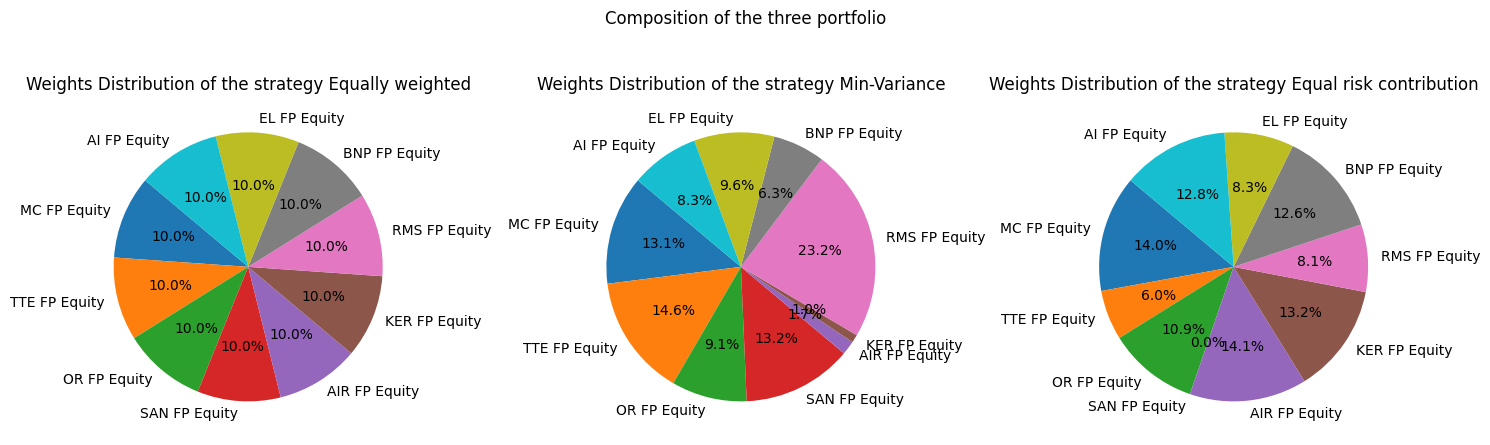

In [54]:
fig, axes = plt.subplots(1,3,figsize=(15, 5))
equally_weighted.generate_weights_distribution(equally_weighted.weights,labels=best_10_index_marketcap,axes = axes[0])
min_variance_portfolio.generate_weights_distribution(np.abs(min_variance_portfolio.weights),labels=best_10_index_marketcap,axes = axes[1])
erc_portfolio.generate_weights_distribution(erc_portfolio.weights,labels=best_10_index_marketcap,axes = axes[2])


fig.suptitle("Composition of the three portfolio")
fig.tight_layout()
# fig.savefig(f'Composition of the three portfolio.pdf')
plt.show()

Regarding the portfolio distribution, we can notice the following statements:

* We see that the ERC strategy tends to distribute more uniformly the portfolio, which can be seen as a more robust distribution of capital
* Min Variance has a tendency to shut investment of risky assets in favor of non-risky assets

## Bibliography

1) Equal Risk Contribution (ERC) Portfolio - Graham Capital Management:
    
    Title: Equal Risk Contribution Portfolio

    Author: Graham Capital Management

    URL: https://www.grahamcapital.com/Equal%20Risk%20Contribution%20April%202019.pdf
    
    Publication Date: April 2019

2) ERC Slides - Thierry Roncalli:
    
    Title: ERC Slides

    Author: Thierry Roncalli

    URL: http://thierry-roncalli.com/download/erc-slides.pdf

    Publication Date: Not specified on the source.